In [1]:
#libraries
library(GO.db)
library(topGO)
library(org.Sc.sgd.db)
library(GOSemSim)
library(gridExtra)

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

 

In [44]:
file <- "yeast_uetz"

ont <- "BP"
p <- 0.4
init <- 1

db <- org.Sc.sgd.db
mapping <- "org.Sc.sgd.db"
ID <- "ENSEMBL"

##load all community gene lists
setwd(sprintf("/home/david/Documents/ghsom/%s_hierarchy_communities_%s_%s", file, p, init))

scGO <- godata(OrgDb = mapping, keytype = ID, ont = ont)

[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."


In [19]:
generateMap <- function(filename){
    map <- as.matrix(read.csv(filename, sep=",", header = F))
    communities <- map[,1]
    map <- map[,2:ncol(map)]
    rownames(map) <- communities
    colnames(map) <- communities
    return (map)
}

In [39]:
#background gene list
backgroundFilename <- "all_genes.txt"
allGenes <- scan(backgroundFilename, character())

#shortest path files
shortestPathFiles  <- list.files(pattern="*shortest_path*")

#shortest paths list
shortestPaths <- sapply(shortestPathFiles, generateMap)
names(shortestPaths) <- sapply(names(shortestPaths), function(name) strsplit(name, "_")[[1]][[1]])

#communitiy assignemtns
assignments <- as.matrix(read.csv("assignment_matrix.txt", sep=",", header=F))
rownames(assignments) <- allGenes
colnames <- sapply(1:ncol(assignments), function(i) as.character(i-1))
colnames(assignments) <- colnames

In [21]:
getDepth <- function(com) {
    return(which(apply(assignments, 2, function(i) any(i == com))))
}

getGenes <- function(com){
    return(names(which(assignments[,getDepth(com)] == com)))
}

getSubCommunities <- function(com){
    return(try(as.character(unique(assignments[getGenes(com), getDepth(com) + 1]))))
}

getSuperCommunity <- function(com){
    return(try(as.character(unique(assignments[getGenes(com), getDepth(com) - 1]))))
}

getShortestPath <- function(com){
    return (try(shortestPaths[[com]]))
}

In [22]:
getDistance <- function(c1, c2) {
    
    m1 <- getSuperCommunity(c1)
    m2 <- getSuperCommunity(c2)
    
    if (m1 == m2) return(getShortestPath(m1)[c1, c2])
        
    d1 <- getDepth(c1)
    d2 <- getDepth(c2)
        
    if (d1 == d2) return (2 + getDistance(m1, m2))
        
    if (d1 > d2) return (1 + getDistance(m1, c2))
        
    if (d2 > d1) return (1 + getDistance(c1, m2))
    
}

In [23]:
getDistance("46", "10")

[1] 4

In [24]:
assignments

,0,1,2,3,4
YGR046W,1,4,-1,-1,-1
YCL046W,1,5,20,36,-1
YJL030W,1,6,24,-1,-1
YBR057C,1,5,20,37,-1
YKR026C,1,2,17,33,-1
YFL056C,1,4,-1,-1,-1
YFL061W,1,7,28,-1,-1
YDR174W,1,2,13,-1,-1
YLR303W,1,7,28,-1,-1
YPL211W,1,6,24,-1,-1


In [25]:
getShortestPath("20")

,36,37,38,39
36,0,1,1,2
37,1,0,2,3
38,1,2,0,1
39,2,3,1,0


In [28]:
getGenes("36")

[1] "YCL046W" "YGL208W" "YLR264W"

In [26]:
getGenes("37")

[1] "YBR057C" "YGL192W" "YCL055W" "YDR477W" "YGL115W" "YER027C" "YOL149W"

In [29]:
getGenes("38")

[1] "YEL015W"

In [30]:
getGenes("39")

[1] "YNL118C"

In [34]:
communities

ERROR: Error in eval(expr, envir, enclos): object 'communities' not found


In [31]:
getGenes(getSuperCommunity("20"))

[1] "YCL046W" "YBR057C" "YCR050C" "YGL208W" "YNR048W" "YKL015W" "YGL192W"
 [8] "YEL023C" "YEL015W" "YDL110C" "YCL055W" "YLR323C" "YDL011C" "YCR022C"
[15] "YFR057W" "YDL160C" "YGR099W" "YGR057C" "YBR094W" "YLR264W" "YDR315C"
[22] "YJL088W" "YNL118C" "YJR117W" "YKL039W" "YDL017W" "YDR477W" "YGL115W"
[29] "YER027C" "YOR006C" "YOL149W" "YOR078W"

In [32]:
getSuperCommunity("20")

[1] "5"

In [33]:
getShortestPath("1")

,2,3,4,5,6,7,8,9,10,11,12
2,0,1,1,2,2,1,3,2,2,3,3
3,1,0,1,1,1,1,2,1,1,2,2
4,1,1,0,1,2,2,2,2,2,3,3
5,2,1,1,0,1,2,1,2,2,3,3
6,2,1,2,1,0,2,1,1,2,2,2
7,1,1,2,2,2,0,3,2,2,3,3
8,3,2,2,1,1,3,0,2,3,3,3
9,2,1,2,2,1,2,2,0,1,1,1
10,2,1,2,2,2,2,3,1,0,1,1
11,3,2,3,3,2,3,3,1,1,0,2


In [47]:
comms <- unique(assignments[,colnames[2]])

In [53]:
layerMeanSimilarities <- sapply(colnames, function(colname)
    mean(sapply(unique(assignments[,colname][assignments[,colname] != -1]), function(com) 
    mean(mgeneSim(genes = getGenes(com), semData = scGO, measure = "Wang", combine = "BMA", verbose=F)))))

In [54]:
layerMeanSimilarities

0         1         2         3         4 
0.2373103 0.3329718 0.4969348 0.6521012 0.7992000

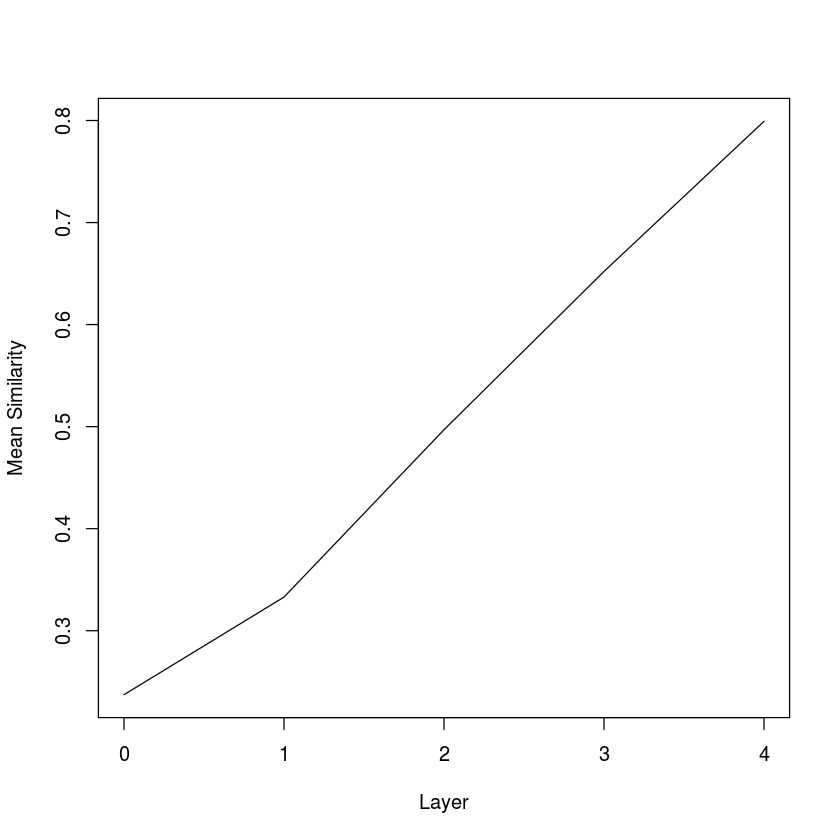

In [57]:
plot(0:4, layerMeanSimilarities, xlab="Layer", ylab="Mean Similarity", type = "l")